This notebook purpose is to try out AutoGluon package open sourced by AWS. The project details is available in link below

https://autogluon.mxnet.io/


# 配置环境

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade mxnet
!pip install autogluon

     |████████████████████████████████| 47.3 MB 1.8 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 273 kB 51.5 MB/s 
     |████████████████████████████████| 352 kB 66.8 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
     |████████████████████████████████| 27.4 MB 1.2 MB/s 
     |████████████████████████████████| 210 kB 59.9 MB/s 
     |████████████████████████████████| 822 kB 48.8 MB/s 
     |████████████████████████████████| 131 kB 58.4 MB/s 
     |████████████████████████████████| 4.2 MB 51.6 MB/s 
     |████████████████████████████████| 119 kB 47.4 MB/s 
     |████████████████████████████████| 1.3 MB 56.3 MB/s 
     |████████████████████████████████| 3.0 MB 58.0 MB/s 
     |███████████████████████

In [3]:
!pip install --upgrade pip
!pip install --upgrade setuptools
!pip install --upgrade "mxnet<2.0.0"
!pip install --pre autogluon

     |████████████████████████████████| 1.7 MB 24.5 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 958 kB 25.8 MB/s            
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import autogluon as ag

In [5]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 数据读取

In [7]:
id, label = 'Id','price'
column = ['carid','tradetime','brand','serial','model','mileage','color','cityid','carcode','transfercount','seatings','registerdate','licensedate','country','maketype','modelyear','displacement','gearbox','oiltype','newprice','anony1','anony2','anony3','anony4','anony5','anony6','anony7','anony8','anony9','anony10','anony11','anony12','anony13','anony14','anony15','price']
df0 =  pd.read_table("/content/drive/MyDrive/附件1：估价训练数据.txt",header=None,names=column)
df1 =  pd.read_table("/content/drive/MyDrive/附件2：估价验证数据.txt",header=None,names=column)

In [8]:
df = pd.concat([df0,df1],ignore_index=True)

In [9]:
print(df0.shape)
print(df1.shape)
print(df.shape)

(30000, 36)
(5000, 36)
(35000, 36)


# 日期、尺寸、国家、anony11（1+2那些的）转换

In [10]:
# 日期转化
def date2num(day):
    if pd.isna(day):
        return day
    else:
        day = str(day)
        if day[4] == '-':
            year = int((eval(day[:4])-2000))
            if day[5] == '0':
                month = int(eval(day[6:7]))
            if day[5] == '1':
                month = int(eval(day[5:7]))
            if day[8] == '0':
                days = int(eval(day[-1:]))
            else:
                days = int(eval(day[-2:]))
            return int(year*365 + (month-1)*30 + days)
        elif len(day)==8:
            year = int((eval(day[:4])-2000))
            if day[4] == '0':
                month = int(eval(day[5:6]))
            else:
                month = int(eval(day[4:6]))
            return int(year*365 + (month-1)*30)

df['tradetime'] = df['tradetime'].apply(date2num)
df['registerdate'] = df['registerdate'].apply(date2num)
df['licensedate'] = df['licensedate'].apply(date2num)
df['anony7'] = df['anony7'].apply(date2num)
df['anony13'] = df['anony13'].apply(date2num)
df['anony15'] = df['anony15'].apply(date2num)

In [11]:
# 0 779411-779421 无779420 共11类 将该11类转化为0-10数字
def country2country(country):
    if pd.isna(country):
        return country
    elif int(country) == 0:
        return 0
    else:
        count = str(country)
        count = count[4:6]
        if int(count[0]) == 1:
            return int(count[1])
        else:
            return 10
df['country'] = df['country'].apply(country2country)

In [12]:
# anony12数据为xxxx*xxxx*xxxx 判断为车身尺寸，将xxxx*xxxx*xxxx（mm）计算为 V（m^3）
def size2v(size):
    size = str(size)
    if len(size)==14:
        x = eval(size[:4])
        y = eval(size[5:9])
        z = eval(size[10:14])
#         print(x,y,z)
        return x*y*z/1000000000
df['anony12'] = df['anony12'].apply(size2v)

In [13]:
# 转化为类别 0-3 四分类 删除掉两类
def idontknow(cls):
    if pd.isna(cls):
        return cls
    elif cls == '1':
        return int(0)
    elif cls == '1+2':
        return int(1)
    elif cls == '3+2':
        return int(2)
    elif cls == '5':
        return int(4) # 无该元素
    elif cls == '1,3+2':
        return int(5) # 无该元素
    elif cls == '1+2,4+2':
        return int(3)
df['anony11'] = df['anony11'].apply(idontknow)

# 数据清洗

异常值清洗

In [14]:
df.shape

(35000, 36)

In [15]:
max(df['price'])

109000.0

In [16]:
del_list = []
# 删除price高于log（100）的数据
for i in range(30000):
  if df['price'][i]>100:
    del_list.append(i)

for i in range(30000):
  if df['price'][i]>100:
    del_list.append(i)

print('删除%s条数据'%len(del_list))
#drop
df.drop(del_list,inplace=True)

删除198条数据


In [17]:
max(df['price'])

99.99

归一化：对除price和carid以外的所有数据归一化至[0,1]

In [18]:
# # # 归一化
# normal = column[1:-1]
# def norm(cls):
#     '''
#     实现对列Normalization归一化
#     '''
#     df[cls] = df[cls].apply(lambda x: (x - df[cls].min())/(df[cls].max() - df[cls].min()))
#     return cls + '类归一化完成'

# for cls in normal:
#     norm(cls)
#     print(cls + '类归一化完成')

log数据

In [19]:
# 对所有数据取log
column_del_id = column[1:]
for cls in column_del_id:
  df[cls] = df[cls].apply(lambda x:np.log(x+1))
  print(cls + '类log完成')

tradetime类log完成
brand类log完成
serial类log完成
model类log完成
mileage类log完成
color类log完成
cityid类log完成
carcode类log完成
transfercount类log完成
seatings类log完成
registerdate类log完成
licensedate类log完成
country类log完成
maketype类log完成
modelyear类log完成
displacement类log完成
gearbox类log完成
oiltype类log完成
newprice类log完成
anony1类log完成
anony2类log完成
anony3类log完成
anony4类log完成
anony5类log完成
anony6类log完成
anony7类log完成
anony8类log完成
anony9类log完成
anony10类log完成
anony11类log完成
anony12类log完成
anony13类log完成
anony14类log完成
anony15类log完成
price类log完成


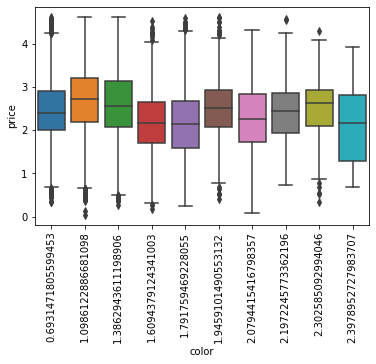

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(data=df,x='color',y='price')
# plt.ylim(0,100)
plt.xticks(rotation=90);

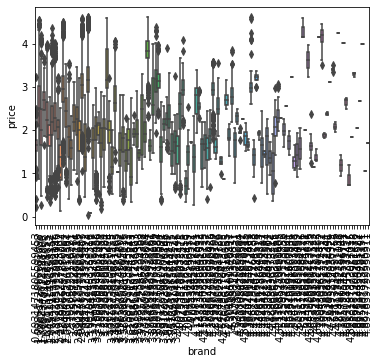

In [21]:
sns.boxplot(data=df,x='brand',y='price')
plt.xticks(rotation=90);

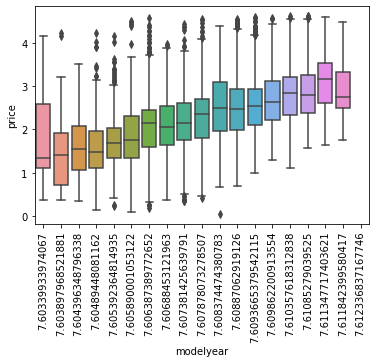

In [22]:
sns.boxplot(data=df,x='modelyear',y='price')
plt.xticks(rotation=90);

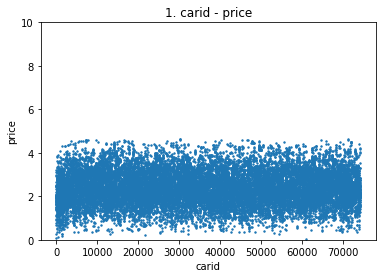

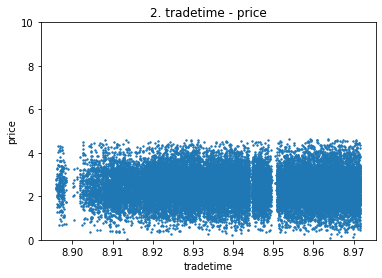

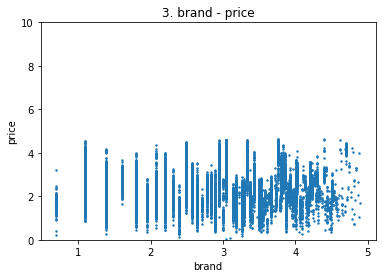

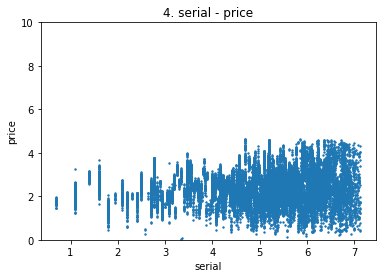

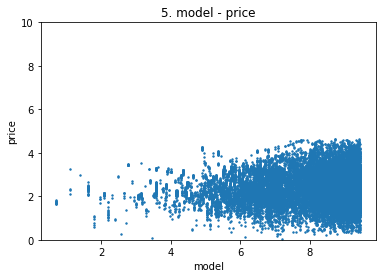

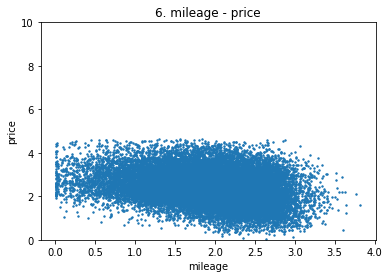

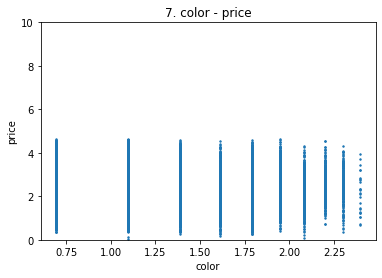

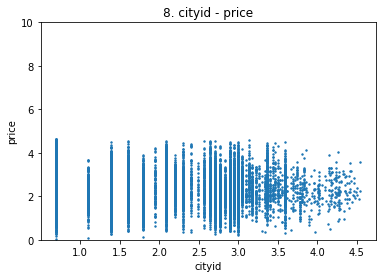

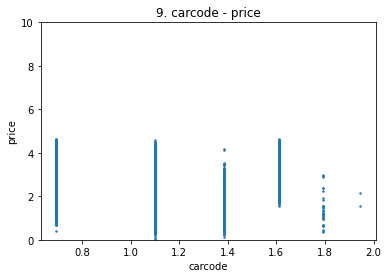

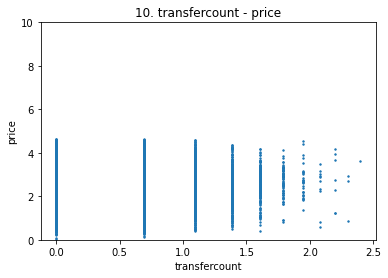

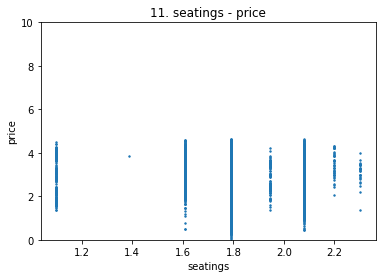

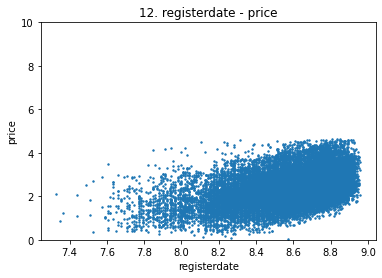

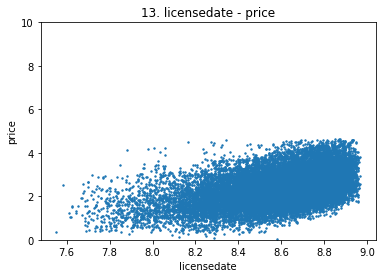

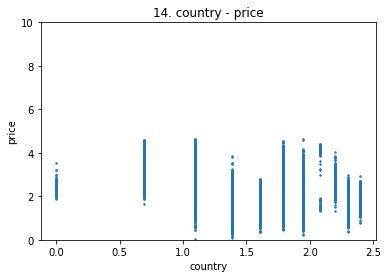

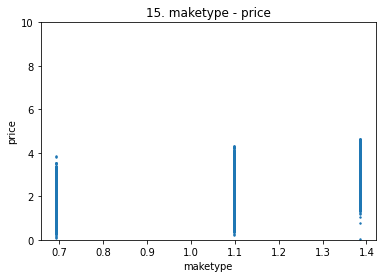

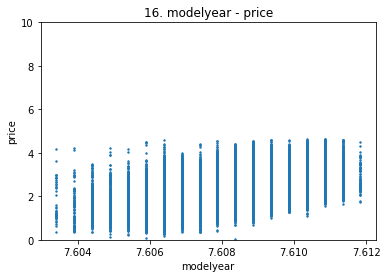

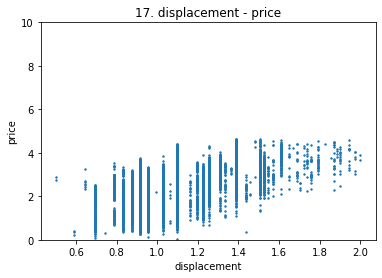

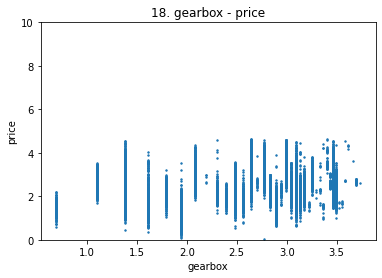

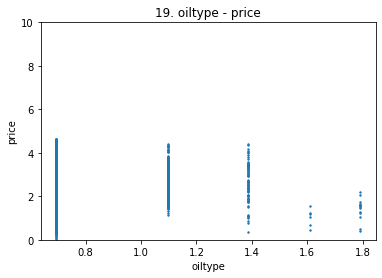

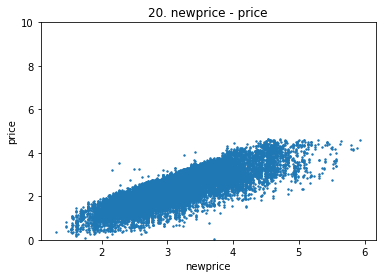

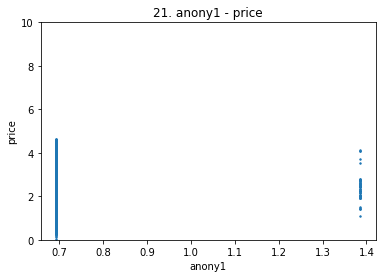

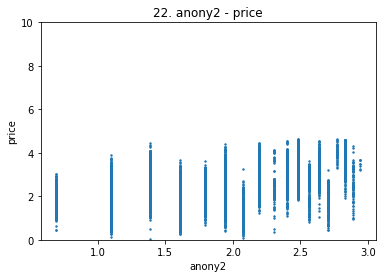

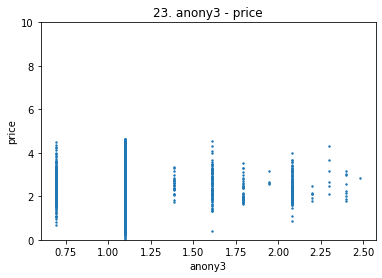

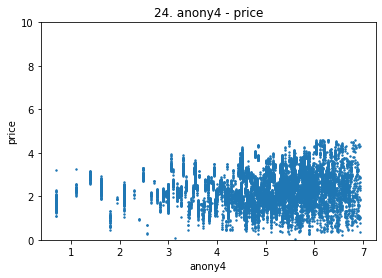

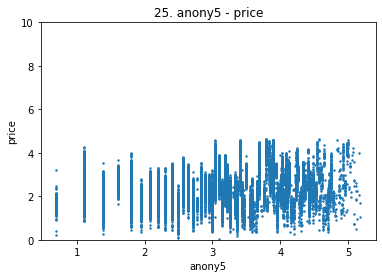

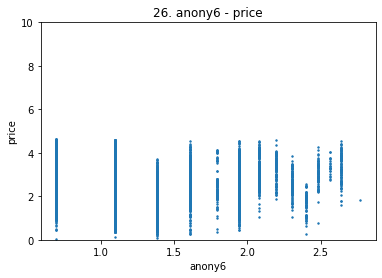

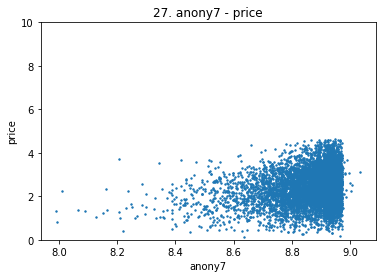

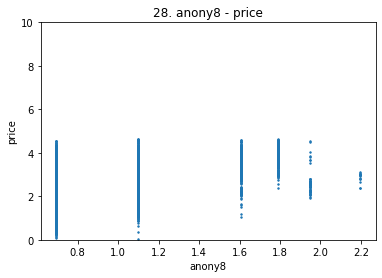

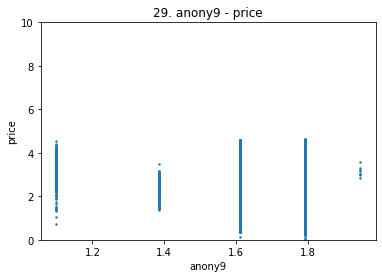

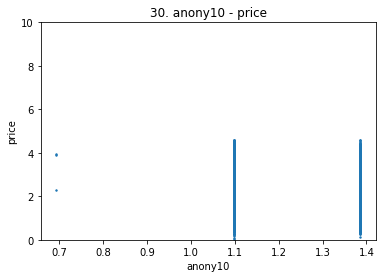

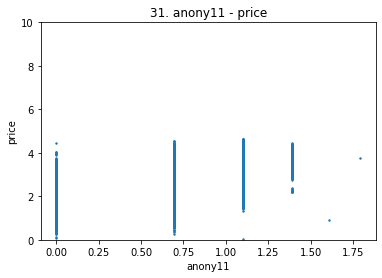

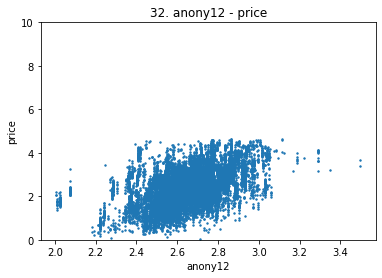

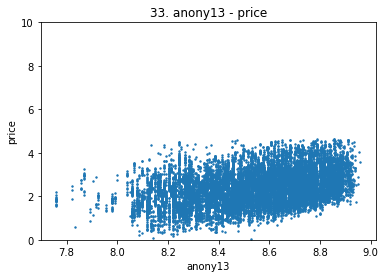

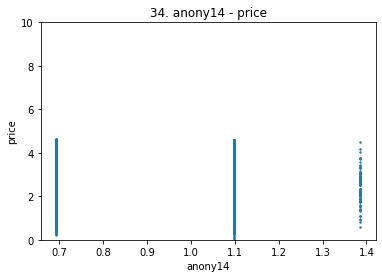

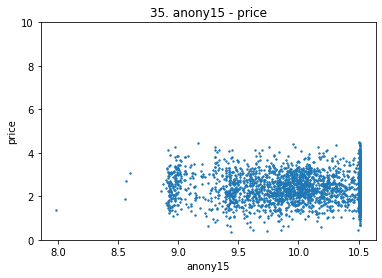

In [23]:
for i in range(35):
    plt.scatter(df[column[i]],df[column[-1]],s=2)
    plt.xlabel(column[i])
    plt.ylabel(column[-1])
    plt.ylim(0,10)
    plt.title(str(i+1) + '. ' + column[i]+' - '+column[-1])
    plt.show()

In [24]:
# 异常值处理 箱型图
# boxp(x=df['color'])


In [25]:
# # 对price取log
# df['price'] = df['price'].apply(lambda x:np.log(x+1))

one-hot编码

In [26]:
# 在onehot_list中选择需要将值改为one-hot编码的因素
onehot_list = ['color','brand','cityid','carcode','seatings','country','displacement','anony1','anony2','anony3','anony6','anony8','anony9','anony10','anony11','anony14']
for cls in onehot_list:
  onehot = pd.get_dummies(df[cls])
  new_col = []
  print(cls + '共' + str(len(onehot.columns))+'类')
  for i in range(len(onehot.columns)):
    new_col.append(cls + '-' +str(i))
  onehot.columns = new_col
  df = pd.concat([df,onehot],axis=1)
  print(cls,'one-hot已成功拼接')
  del df[cls]
  print(cls,'列已删除')

color共10类
color one-hot已成功拼接
color 列已删除
brand共123类
brand one-hot已成功拼接
brand 列已删除
cityid共89类
cityid one-hot已成功拼接
cityid 列已删除
carcode共6类
carcode one-hot已成功拼接
carcode 列已删除
seatings共8类
seatings one-hot已成功拼接
seatings 列已删除
country共11类
country one-hot已成功拼接
country 列已删除
displacement共46类
displacement one-hot已成功拼接
displacement 列已删除
anony1共3类
anony1 one-hot已成功拼接
anony1 列已删除
anony2共18类
anony2 one-hot已成功拼接
anony2 列已删除
anony3共11类
anony3 one-hot已成功拼接
anony3 列已删除
anony6共14类
anony6 one-hot已成功拼接
anony6 列已删除
anony8共6类
anony8 one-hot已成功拼接
anony8 列已删除
anony9共5类
anony9 one-hot已成功拼接
anony9 列已删除
anony10共3类
anony10 one-hot已成功拼接
anony10 列已删除
anony11共6类
anony11 one-hot已成功拼接
anony11 列已删除
anony14共4类
anony14 one-hot已成功拼接
anony14 列已删除


# 分配训练集和测试集

In [27]:
df.shape

(34901, 383)

In [28]:
dataset = TabularDataset(df)

In [29]:
# 选择测试集所占比例rate
rate = 0.99
num_of_train = int((len(dataset)-5000) * rate)
test_data = dataset.iloc[num_of_train:len(dataset)-5000]
train_data = dataset.iloc[:num_of_train]
print(train_data.shape)
print(test_data.shape)

(29601, 383)
(300, 383)


In [30]:
train_data.shape

(29601, 383)

In [31]:
len(train_data['price'])

29601

# 训练模型

In [32]:
predictor = TabularPredictor(label = 'price',eval_metric='root_mean_squared_error').fit(train_data.drop(columns=['carid']))

No path specified. Models will be saved in: "AutogluonModels/ag-20220119_140133/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220119_140133/"
AutoGluon Version:  0.3.1
Train Data Rows:    29601
Train Data Columns: 381
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (4.6150215020384655, 0.04879016416943205, 2.44416, 0.71601)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12654.16 MB
	Train Data (Original)  Memory Usage: 15.01 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_m

[1000]	train_set's rmse: 0.0735504	valid_set's rmse: 0.094968
[2000]	train_set's rmse: 0.0592434	valid_set's rmse: 0.0914039
[3000]	train_set's rmse: 0.0504882	valid_set's rmse: 0.0904025
[4000]	train_set's rmse: 0.0442713	valid_set's rmse: 0.0899459
[5000]	train_set's rmse: 0.0395593	valid_set's rmse: 0.0897044
[6000]	train_set's rmse: 0.0357998	valid_set's rmse: 0.0896536
[7000]	train_set's rmse: 0.0327109	valid_set's rmse: 0.0897017


	-0.0896	 = Validation score   (root_mean_squared_error)
	30.94s	 = Training   runtime
	0.84s	 = Validation runtime
Fitting model: LightGBM ...
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 0.0672384	valid_set's rmse: 0.0941599
[2000]	train_set's rmse: 0.0506783	valid_set's rmse: 0.0910624
[3000]	train_set's rmse: 0.0410681	valid_set's rmse: 0.0903489
[4000]	train_set's rmse: 0.0344832	valid_set's rmse: 0.0900418
[5000]	train_set's rmse: 0.0296753	valid_set's rmse: 0.0898816
[6000]	train_set's rmse: 0.0259198	valid_set's rmse: 0.0896886
[7000]	train_set's rmse: 0.023128	valid_set's rmse: 0.0897589


	-0.0897	 = Validation score   (root_mean_squared_error)
	33.56s	 = Training   runtime
	0.86s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.1058	 = Validation score   (root_mean_squared_error)
	154.2s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: CatBoost ...
	-0.0895	 = Validation score   (root_mean_squared_error)
	54.14s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.1019	 = Validation score   (root_mean_squared_error)
	128.02s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.1254	 = Validation score   (root_mean_squared_error)
	57.97s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: XGBoost ...
	-0.0925	 = Validation score   (root_mean_squared_error)
	21.69s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: NeuralNetMXNet ...
	-0.1007	 = Validation score   (root_mean_squared_error)
	449.38s	 = Training   runtime
	1.83s	 = Validation ru

[1000]	train_set's rmse: 0.0404019	valid_set's rmse: 0.0924417
[2000]	train_set's rmse: 0.0250272	valid_set's rmse: 0.0914882
[3000]	train_set's rmse: 0.0182513	valid_set's rmse: 0.0912324
[4000]	train_set's rmse: 0.0151089	valid_set's rmse: 0.0911844
[5000]	train_set's rmse: 0.0137001	valid_set's rmse: 0.0911837


	-0.0912	 = Validation score   (root_mean_squared_error)
	66.4s	 = Training   runtime
	1.36s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.0861	 = Validation score   (root_mean_squared_error)
	0.36s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 1033.17s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220119_140133/")


In [33]:
predictor.leaderboard(test_data)

                  model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   -0.083853  -0.086102        2.798177       7.387389  820.802254                 0.043249                0.000676           0.359854            2       True         12
1         LightGBMLarge   -0.086788  -0.091157        0.583062       1.356761   66.395714                 0.583062                1.356761          66.395714            1       True         11
2         ExtraTreesMSE   -0.087253  -0.101940        0.670110       0.308732  128.022923                 0.670110                0.308732         128.022923            1       True          7
3            LightGBMXT   -0.087538  -0.089605        0.304787       0.842825   30.944162                 0.304787                0.842825          30.944162            1       True          3
4              CatBoost   -0.088954

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.083853,-0.086102,2.798177,7.387389,820.802254,0.043249,0.000676,0.359854,2,True,12
1,LightGBMLarge,-0.086788,-0.091157,0.583062,1.356761,66.395714,0.583062,1.356761,66.395714,1,True,11
2,ExtraTreesMSE,-0.087253,-0.101940,0.670110,0.308732,128.022923,0.670110,0.308732,128.022923,1,True,7
3,LightGBMXT,-0.087538,-0.089605,0.304787,0.842825,30.944162,0.304787,0.842825,30.944162,1,True,3
4,CatBoost,-0.088954,-0.089534,0.030149,0.048647,54.141382,0.030149,0.048647,54.141382,1,True,6
5,LightGBM,-0.090134,-0.089679,0.283640,0.860162,33.559134,0.283640,0.860162,33.559134,1,True,4
6,XGBoost,-0.091755,-0.092503,0.299209,0.115014,21.687296,0.299209,0.115014,21.687296,1,True,9
7,RandomForestMSE,-0.093006,-0.105764,0.643981,0.308700,154.196788,0.643981,0.308700,154.196788,1,True,5
8,NeuralNetMXNet,-0.095588,-0.100727,0.340994,1.826759,449.380884,0.340994,1.826759,449.380884,1,True,10
9,NeuralNetFastAI,-0.099677,-0.125396,0.132406,0.210397,57.970885,0.132406,0.210397,57.970885,1,True,8


# 预测

In [34]:
# make prediction
y_pred = predictor.predict(test_data.drop(columns=['carid','price']))
y = test_data['price']

In [35]:
# 若对数据进行了log记得还原
y_pred = np.exp(y_pred) - 1
y = np.exp(y) - 1

In [36]:
#模型评测标准
def accurate(y,y_pred):
    Ape = np.abs(y_pred-y)/y # 此处Ape还是Tensor类型数据
    Ape = np.array(Ape)
    Mape = np.mean(Ape)
    countApe5 = np.sum(Ape<=0.05)
    Accuracy5 = countApe5/y.shape[0]
    value = 0.2*(1-Mape)+0.8*Accuracy5
    print('Mape: %f, Accuracy0.05: %f' %(Mape,Accuracy5))
    return value
print('最终得分: ',accurate(y,y_pred))

Mape: 0.070845, Accuracy0.05: 0.503333
最终得分:  0.5884977490148929


# 价格预测

In [37]:
dataset.shape

(34901, 383)

In [38]:
x = dataset.iloc[-5000:]
x
price_pred = predictor.predict(x.drop(columns=['carid','price']))
price_pred = np.exp(price_pred) - 1

In [39]:
print(min(price_pred))
print(max(price_pred))

0.09350097179412842
124.85186004638672


In [40]:
price_pred

30000    17.020157
30001     8.697906
30002     2.025348
30003     6.080846
30004    15.253195
           ...    
34995    20.484474
34996     4.042965
34997     5.912731
34998     2.177700
34999    12.453946
Name: price, Length: 5000, dtype: float32

In [41]:
x['carid']

30000        3
30001        4
30002        8
30003        9
30004       11
         ...  
34995    55510
34996     1768
34997    20723
34998    15625
34999    51844
Name: carid, Length: 5000, dtype: int64

In [42]:
result = pd.concat([x['carid'],price_pred],axis=1)

In [43]:
result.shape

(5000, 2)

In [44]:
result.to_csv('final_result.txt', sep='\t', index=False)

# 实验记录

1、使用原数据：
  Mape: 0.385935, Accuracy5: 0.432167
  最终得分:  0.4685462679169581



2、对除了price进行normalization:
  Mape: 0.430817, Accuracy5: 0.412500
  最终得分: 0.4438366100986704



3、将所有数据log处理：
  Mape: 0.069159, Accuracy5: 0.513000
  最终得分:  0.596568114006245

4、对除了price使用Normalization，对price使用log：
  Mape: 0.068416, Accuracy5: 0.513500
  最终得分:  0.5971168201579876



5、对所有数据log处理，['color','brand','cityid','carcode','seatings','country','displacement','anony1','anony2','anony3','anony6','anony8','anony9','anony10','anony11','anony14']修改为独热码（380预测1）
Mape: 0.066347, Accuracy5: 0.511333
最终得分:  0.5957972281293993：

6、在5之上删除价格大于100的数据：Mape: 0.063763, Accuracy5: 0.535284
最终得分:  0.6154748315632879

7、在6之上删除anony15列:Mape: 0.063574, Accuracy5: 0.532274
最终得分:  0.6131045292796926

Mape: 0.06, Accuracy(error<0.05): 0.54 最终得分: 0.62